# Imports

In [808]:
start_time = time.time()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import re
import time
from sklearn.impute import KNNImputer

chunksize = 10 ** 3  # Chunksize de 1000 lignes
filename = 'products.csv'
nan_rates = []

try:
    reader = pd.read_csv(filename, chunksize=chunksize, sep='\t')

    for chunk in reader:
        nan_rates.append(chunk.isna().mean(axis=0))

except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

# Calcul des taux moyens de remplissage des chunks
if nan_rates:
    inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)
    cols_to_load = inds_nan_rate[inds_nan_rate < 0.7].index.tolist()

    # Chargement des données filtrées
    df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)
    df = df.drop(['url','states','additives_n','energy_100g','main_category','completeness','nutrient_levels_tags','brands','nova_group','food_groups','categories','creator','pnns_groups_1','serving_size','serving_quantity','categories','image_nutrition_url','ingredients_analysis_tags','ingredients_tags','ingredients_text','image_nutrition_small_url','pnns_groups_2','created_datetime','food_groups_tags','food_groups_en','states_tags','sodium_100g','states_en','last_image_datetime','last_modified_t','last_modified_datetime','created_t','last_modified_by','main_category_en','image_url','image_small_url','last_updated_t','last_image_t','brands_tags','last_updated_datetime','categories_en','categories_tags','countries_tags','countries_en'], axis=1)
    print(df.head())
    
# Liste des mots clés à rechercher dans la colonne 'countries'
keywords = ['France', 'French', 'Francia', 'Frankreich', 'Polynésie française', 'FR', 'fr']

# Remplacer les valeurs NaN par une chaîne vide pour éviter les erreurs de filtrage
df['countries'].fillna('', inplace=True)

# Filtrer les lignes où 'countries' ne contient pas les mots clés spécifiés
mask = df['countries'].str.contains('|'.join(keywords), case=False, na=False)
df = df[mask]

ParserError: Error tokenizing data. C error: Expected 206 fields in line 1537879, saw 234



/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_1633/3498310821.py:32: DtypeWarning: Columns (0,50,52,56,58,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)


                     code      product_name  countries nutriscore_score  \
0       00000000000000225    jeunes pousses  en:france              NaN   
1  0000000000000207025004             Andrè      en:de              NaN   
2    00000000000003429145           L.casei      Spain              NaN   
3    00000000000026772226              Skyr     France            -5.00   
4           0000000000017  Vitória crackers     France              NaN   

  nutriscore_grade ecoscore_grade energy-kcal_100g fat_100g  \
0          unknown              b              NaN      NaN   
1          unknown        unknown           165.00     2.00   
2          unknown        unknown              NaN     1.40   
3                a              b            57.00     0.20   
4          unknown        unknown           375.00     7.00   

  saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0                NaN                 NaN          NaN         NaN   
1               2.00            

# Information Dataframe

In [810]:
df.info

<bound method DataFrame.info of                          code                  product_name        countries  \
0           00000000000000225                jeunes pousses        en:france   
3        00000000000026772226                          Skyr           France   
4               0000000000017              Vitória crackers           France   
5               0000000000031                         Cacao           France   
11              0000000000100   moutarde au moût de raisin            France   
...                       ...                           ...              ...   
3307643              99999995                Steak haché 5%           France   
3307647         9999999905667                           NaN  en:South Africa   
3307649         9999999916298       Beurre de cacahuète bio            en:fr   
3307652             999999999       Thé noir BIO Darjeeling        en:france   
3307657         9999999999994     Light & Free SKYR A BOIRE        en:france   

       

In [811]:
df.head(5)

,code,product_name,countries,nutriscore_score,nutriscore_grade,ecoscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,00000000000000225,jeunes pousses,en:france,NaN,unknown,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000000026772226,Skyr,France,-5.00,a,b,57.00,0.20,0.10,3.90,3.90,NaN,10.00,0.09,NaN,-5.00
4,0000000000017,Vitória crackers,France,NaN,unknown,unknown,375.00,7.00,3.08,70.10,15.00,NaN,7.80,1.40,NaN,NaN
5,0000000000031,Cacao,France,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0000000000100,moutarde au moût de raisin,France,18.00,d,c,NaN,8.20,2.20,29.00,22.00,0.00,5.10,4.60,0.00,18.00


In [812]:
df.dtypes

code                                                      object
product_name                                              object
countries                                                 object
nutriscore_score                                          object
nutriscore_grade                                          object
ecoscore_grade                                            object
energy-kcal_100g                                          object
fat_100g                                                  object
saturated-fat_100g                                        object
carbohydrates_100g                                       float64
sugars_100g                                              float64
fiber_100g                                               float64
proteins_100g                                            float64
salt_100g                                                float64
fruits-vegetables-nuts-estimate-from-ingredients_100g    float64
nutrition-score-fr_100g  

# Nettoyage Données

In [814]:
def clean_and_impute_data(df):
    def detect_and_remove_cyrillic(df, column):
        cyrillic_pattern = re.compile(r'[\u0400-\u04FF]+')
        cyrillic_indices = df[df[column].apply(lambda x: bool(cyrillic_pattern.search(str(x))))].index
        df.drop(cyrillic_indices, inplace=True)
        df.reset_index(drop=True, inplace=True)
        print(f"\nNombre de lignes supprimées : {len(cyrillic_indices)}")
        print("Étape de suppression des caractères cyrilliques complétée.")

    def redistribute_nutrient_values(row, columns_to_check, max_sum=100):
        total = row[columns_to_check].sum()
        if total > max_sum:
            factor = max_sum / total
            row[columns_to_check] *= factor
        return row

    def check_nutrient_sum(df):
        columns_to_check = ['fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']
        nutrient_sum = df[columns_to_check].sum(axis=1)
        rows_with_high_sum = df[nutrient_sum > 100].copy()

        for idx, row in rows_with_high_sum.iterrows():
            df.loc[idx, columns_to_check] = redistribute_nutrient_values(row, columns_to_check)

        count_high_sum = rows_with_high_sum.shape[0]

        if count_high_sum > 0:
            print(f"\nNombre de lignes avec une somme strictement supérieure à 100 : {count_high_sum}")
        else:
            print("Aucune ligne avec une somme des colonnes strictement supérieure à 100 trouvée.")

        return count_high_sum

    # Suppression cyrillique
    detect_and_remove_cyrillic(df, 'product_name')

    # Focalisation sur le marché français
    keywords = ['France', 'French', 'Francia', 'Frankreich', 'Polynésie française', 'FR', 'fr']
    df['countries'].fillna('', inplace=True)
    df = df[df['countries'].str.contains('|'.join(keywords), case=False, na=False)]
    print("Étape de focalisation sur le marché français complétée.")

    # Suppression des doublons basés sur le code
    df.drop_duplicates(subset='code', inplace=True)
    print("Étape de suppression des doublons basée sur le code complétée.")

    # Remplacement des valeurs >100 par la moyenne en fonction du 'product_name'
    columns_to_check = [
        'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 
        'fruits-vegetables-nuts-estimate-from-ingredients_100g'
    ]

    df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')
    means = df.groupby('product_name')[columns_to_check].transform('mean')

    for column in columns_to_check:
        df[column] = np.where(df[column] > 100, means[column], df[column])

    values_above_100 = df[columns_to_check] > 100
    count_above_100 = values_above_100.sum().sum()
    print(f"Nombre de valeurs supérieures à 100 après correction : {count_above_100}")

    df.drop(index=df[values_above_100.any(axis=1)].index, inplace=True)
    print("Étape de remplacement des valeurs >100 par la moyenne complétée.")

    # Imputation itérative des NaN pour 'energy-kcal_100g' entre 0 et 900
    modified_count_energy = 0
    imputer_energy = IterativeImputer(max_iter=50, tol=0.001, sample_posterior=True, random_state=0, min_value=0, max_value=900)
    df_imputed_energy = imputer_energy.fit_transform(df[['energy-kcal_100g']])

    modified_count_energy += df['energy-kcal_100g'].isna().sum() - np.isnan(df_imputed_energy).sum()

    df['energy-kcal_100g'] = df_imputed_energy
    df['energy-kcal_100g'] = df['energy-kcal_100g'].round(2)

    print(f"Nombre de valeurs modifiées pour 'energy-kcal_100g' : {modified_count_energy}")
    print("Étape d'imputation itérative des NaN pour 'energy-kcal_100g' complétée.")

    # Imputation itérative des NaN pour les colonnes de nutriments entre 0 et 100
    modified_count_nutrients = 0
    imputer_nutrients = IterativeImputer(max_iter=50, tol=0.001, sample_posterior=True, random_state=0, min_value=0, max_value=100)
    df_imputed_nutrients = imputer_nutrients.fit_transform(df[columns_to_check])

    for idx, column in enumerate(columns_to_check):
        modified_count_nutrients += df[column].isna().sum() - np.isnan(df_imputed_nutrients[:, idx]).sum()

    df[columns_to_check] = df_imputed_nutrients
    df[columns_to_check] = df[columns_to_check].round(2)

    print(f"Nombre de valeurs modifiées pour les colonnes de nutriments : {modified_count_nutrients}")
    print("Étape d'imputation itérative des NaN pour les colonnes de nutriments complétée.")

    # Suppression des lignes avec des valeurs NaN dans 'product_name'
    nombre_lignes_avant = df.shape[0]
    df.dropna(subset=['product_name'], inplace=True)
    nombre_lignes_apres = df.shape[0]
    nombre_lignes_supprimees = nombre_lignes_avant - nombre_lignes_apres
    print(f"\nNombre de lignes supprimées: {nombre_lignes_supprimees}")
    print("Étape de suppression des lignes avec des NaN dans 'product_name' complétée.")

    # Suppression des lignes avec des valeurs négatives dans les colonnes spécifiées
    negative_values = {}
    for column in columns_to_check:
        count_negatives = df[df[column] < 0].shape[0]
        if count_negatives > 0:
            negative_values[column] = count_negatives
            df = df[df[column] >= 0]

    print("\nRésumé des lignes supprimées contenant des valeurs négatives :")
    for column, count in negative_values.items():
        print(f"Colonne '{column}': {count} lignes supprimées contenant des valeurs négatives")
    print("Étape de suppression des lignes avec des valeurs négatives complétée.")

    # Suppression des lignes où 'energy-kcal_100g' est supérieur à 900
    high_energy_rows = df[df['energy-kcal_100g'] > 900]
    count_high_energy = high_energy_rows.shape[0]
    print(f"Nombre de lignes où 'energy-kcal_100g' est supérieur à 900 : {count_high_energy}")

    df.drop(index=high_energy_rows.index, inplace=True)

    print("\nAprès suppression :")
    high_energy_rows_after = df[df['energy-kcal_100g'] > 900]
    count_high_energy_after = high_energy_rows_after.shape[0]
    print(f"Nombre de lignes restantes où 'energy-kcal_100g' est supérieur à 900 : {count_high_energy_after}")
    print("Étape de suppression des lignes où 'energy-kcal_100g' est supérieur à 900 complétée.")

    # Redistribution des valeurs si la somme des colonnes dépasse 100
    modified_counter = 0
    modified_counter += check_nutrient_sum(df)

    print(f"\nNombre de valeurs modifiées pendant la redistribution : {modified_counter}")
    print("Étape de redistribution des valeurs complétée.")

    return df


In [815]:
df = clean_and_impute_data(df)


Nombre de lignes supprimées : 424
Étape de suppression des caractères cyrilliques complétée.
Étape de focalisation sur le marché français complétée.
Étape de suppression des doublons basée sur le code complétée.
Nombre de valeurs supérieures à 100 après correction : 1290
Étape de remplacement des valeurs >100 par la moyenne complétée.
Nombre de valeurs modifiées pour 'energy-kcal_100g' : 278078
Étape d'imputation itérative des NaN pour 'energy-kcal_100g' complétée.
Nombre de valeurs modifiées pour les colonnes de nutriments : 3158649
Étape d'imputation itérative des NaN pour les colonnes de nutriments complétée.

Nombre de lignes supprimées: 34975
Étape de suppression des lignes avec des NaN dans 'product_name' complétée.

Résumé des lignes supprimées contenant des valeurs négatives :
Colonne 'sugars_100g': 1 lignes supprimées contenant des valeurs négatives
Colonne 'fruits-vegetables-nuts-estimate-from-ingredients_100g': 136 lignes supprimées contenant des valeurs négatives
Étape de 

# Fin Test

In [817]:
df.isna().mean()

code                                                    0.00
product_name                                            0.00
countries                                               0.00
nutriscore_score                                        0.51
nutriscore_grade                                        0.01
ecoscore_grade                                          0.00
energy-kcal_100g                                        0.00
fat_100g                                                0.00
saturated-fat_100g                                      0.00
carbohydrates_100g                                      0.00
sugars_100g                                             0.00
fiber_100g                                              0.00
proteins_100g                                           0.00
salt_100g                                               0.00
fruits-vegetables-nuts-estimate-from-ingredients_100g   0.00
nutrition-score-fr_100g                                 0.51
dtype: float64

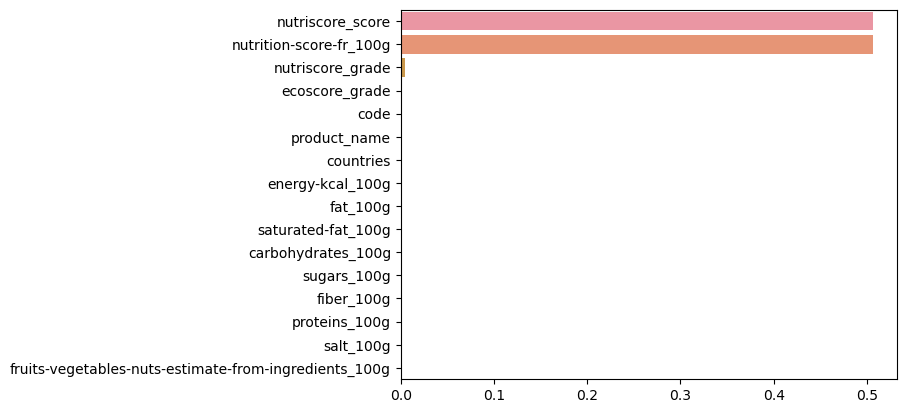

In [818]:
valeurs_manq = df.isna().mean().sort_values(ascending=False)
sns.barplot(x=valeurs_manq.values, y=valeurs_manq.index);

## Test fin

In [820]:
zero_percentages = (df == 0).sum() / df.shape[0] * 100
nan_percentages = df.isna().sum() / df.shape[0] * 100
print("Pourcentage des valeurs égales à 0 :")
print(zero_percentages)
print("\nPourcentage des NaN :")
print(nan_percentages)

Pourcentage des valeurs égales à 0 :
code                                                     0.00
product_name                                             0.00
countries                                                0.00
nutriscore_score                                         2.38
nutriscore_grade                                         0.00
ecoscore_grade                                           0.00
energy-kcal_100g                                         2.17
fat_100g                                                10.57
saturated-fat_100g                                      15.37
carbohydrates_100g                                       6.98
sugars_100g                                             11.95
fiber_100g                                               9.40
proteins_100g                                            8.83
salt_100g                                               12.69
fruits-vegetables-nuts-estimate-from-ingredients_100g   21.05
nutrition-score-fr_100g          

In [821]:
df.head(10)

,code,product_name,countries,nutriscore_score,nutriscore_grade,ecoscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
1,00000000000026772226,Skyr,France,-5.00,a,b,57.00,0.20,0.10,3.90,3.90,0.41,10.00,0.09,45.12,-5.00
2,0000000000017,Vitória crackers,France,NaN,unknown,unknown,375.00,7.00,3.08,70.10,15.00,10.75,7.80,1.40,64.84,NaN
5,0000000000123,Sauce Sweety chili 0%,France,NaN,unknown,unknown,21.00,0.00,0.00,4.80,0.40,9.47,0.20,2.04,46.53,NaN
6,0000000000178,Mini coco,France,NaN,unknown,unknown,60.00,3.00,1.00,10.00,3.00,3.82,2.00,1.15,7.23,NaN
8,000000000025,Thé noir glacé pomme,en:fr,NaN,unknown,unknown,52.00,0.50,0.10,12.00,11.00,5.11,0.50,3.19,48.27,NaN
14,000000000080,Pur jus de pomme,en:fr,9.00,d,c,63.00,0.00,0.00,15.50,15.50,0.00,0.20,0.00,20.11,9.00
18,0000000000949,Salade de carottes râpées,France,-4.00,a,b,32.00,0.30,0.10,5.30,3.90,0.00,0.90,0.42,2.24,-4.00
19,0000000000970,Fromage blanc aux myrtilles,France,NaN,unknown,unknown,129.00,4.90,3.10,16.30,16.30,4.24,4.40,0.25,43.43,NaN
22,0000000001137,Baguette parisien,France,NaN,unknown,unknown,222.00,3.30,2.10,38.40,1.80,3.75,11.70,0.68,38.78,NaN
24,0000000001151,&quot;Baguette Lyonnais&quot;,France,NaN,unknown,unknown,290.00,9.40,4.50,41.00,2.00,9.89,12.50,0.90,28.64,NaN


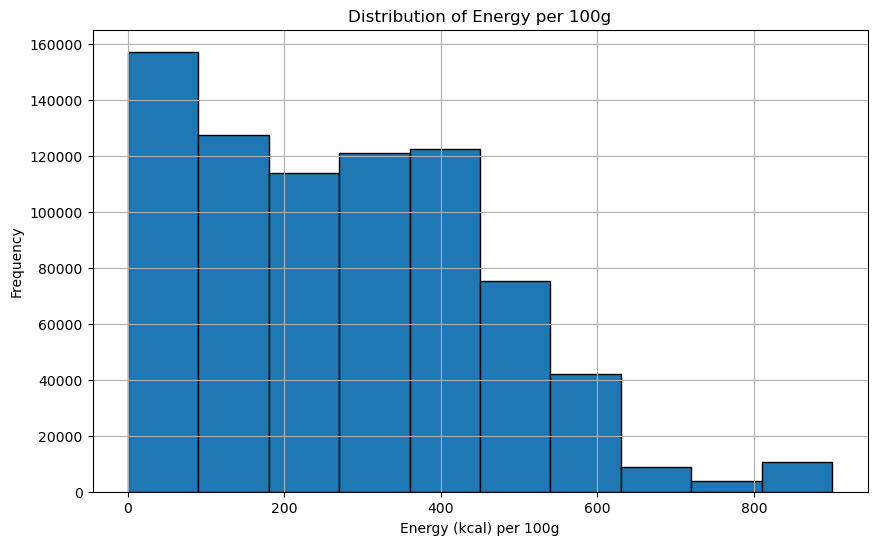

In [822]:
plt.figure(figsize=(10, 6))
plt.hist(df['energy-kcal_100g'], edgecolor='black')
plt.xlabel('Energy (kcal) per 100g')
plt.ylabel('Frequency')
plt.title('Distribution of Energy per 100g')
plt.grid(True)
plt.show()

# Timer

In [824]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Temps d'exécution total du notebook : {execution_time:.4f} secondes")

Temps d'exécution total du notebook : 416.7235 secondes
